<a href="https://colab.research.google.com/github/wwh133/Transformer/blob/main/%E7%AC%AC%E4%B8%89%E7%AB%A0_%E5%BE%AE%E8%B0%83bert_%E9%A2%84%E8%AE%AD%E7%BB%83%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Sentence Classification
Copyright 2022-2023 Denis Rothman. The text cells were taken out and replaced by titles of each cell within the cell. The titles of the cells refer to the titles of the sections of the book. The descriptions of the cells have been rewritten for educational purposes.

This notebook shows how to fine-tune a transformer model. Many pretrained and fine-tuned transformer models are available online. Some models, such as GPT-3, do not even need to be fine-tuned.  These ready-to-use models can even be accessed through an API.

However, it is highly recommended to understand this notebook to grasp the architecture of transformer models.

掌握transformer模型的架构。


Contributer: George Mihaila

[Reference Notebook by Chris McCormick and Nick Ryan](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)

[Reference Article by Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

In [1]:
from IPython.display import Image     #This is used for rendering images in the notebook

In [2]:
#@title Installing the Hugging Face PyTorch Interface for Bert / TensorFlow
# !pip install pytorch-pretrained-bert pytorch-nlp
!pip install -q transformers

In [3]:
#@title Importing the modules
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#March 2023 update
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # 词元化
            # 优化器     序列分类
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
         # 进度条
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
#March 2023 update:
#% matplotlib inline

训练transformer模型必须要用GPU

In [4]:
#@title Hardware verification and device attribution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Fri Apr 26 12:27:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   48C    P8              12W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

@article{warstadt2018neural,
    title={Neural Network Acceptability Judgments},
    author={Warstadt, Alex and Singh, Amanpreet and Bowman, Samuel R},
    journal={arXiv preprint arXiv:1805.12471},
    year={2018}
}


#Loading the dataset
加载数据集

In [5]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1144k      0 --:--:-- --:--:-- --:--:-- 1145k


In [6]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k


In [7]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [8]:
df.sample(10) # 随机抽样
# 0=不可接受；1=可接受
df.head(10)

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .
5,gj04,1,NaN,i 'll fix you a drink .
6,gj04,1,NaN,fred watered the plants flat .
7,gj04,1,NaN,bill coughed his way out of the restaurant .
8,gj04,1,NaN,we 're dancing the night away .
9,gj04,1,NaN,herman hammered the metal flat .


#Creating sentences, label lists, and adding BERT tokens

In [9]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values
print(sentences[:5])

["our friends wo n't buy this analysis , let alone the next one we propose ."
 "one more pseudo generalization and i 'm giving up ."
 "one more pseudo generalization or i 'm giving up ."
 'the more we study verbs , the crazier they get .'
 'day by day the facts are getting murkier .']


In [10]:
# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
print(sentences[:5])
labels = df.label.values

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]", "[CLS] one more pseudo generalization and i 'm giving up . [SEP]", "[CLS] one more pseudo generalization or i 'm giving up . [SEP]", '[CLS] the more we study verbs , the crazier they get . [SEP]', '[CLS] day by day the facts are getting murkier . [SEP]']


In [11]:
#@title Activating the BERT Tokenizer 词元分析器
# 预训练的词元分析器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [12]:
#@title Processing the data 处理数据
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# 训练集中最长的序列是47，但我们还是会在最后留下空间。
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(input_ids)
# Pad our input tokens 填充输入标记0
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(input_ids)

[[101, 2256, 2814, 24185, 1050, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 1996, 2062, 2057, 2817, 16025, 1010, 1996, 13675, 16103, 2121, 2027, 2131, 1012, 102], [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102], [101, 1045, 1005, 2222, 8081, 2017, 1037, 4392, 1012, 102], [101, 5965, 27129, 1996, 4264, 4257, 1012, 102], [101, 3021, 19055, 2010, 2126, 2041, 1997, 1996, 4825, 1012, 102], [101, 2057, 1005, 2128, 5613, 1996, 2305, 2185, 1012, 102], [101, 11458, 25756, 1996, 3384, 4257, 1012, 102], [101, 1996, 4401, 4191, 1996, 2377, 2125, 1996, 2754, 1012, 102], [101, 1996, 8644, 10619, 5024, 1012, 102], [101, 3021, 4565, 2041, 1997, 1996, 2282, 1012, 102], [101, 1996, 19785, 27129, 1996, 4870, 4257, 1012, 102], [101, 1996, 19785, 27129, 1996

In [13]:
#@title Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
# 大于0，有效词元，掩码1；反之，填充词元，掩码0
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
#@title Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                      random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

print(train_inputs)
print(train_labels)
print(train_masks)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
#@title Converting all the data into torch tensors 转换成张量
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

print(train_inputs)
print(train_labels)
print(train_masks)

tensor([[  101,  2002,  2939,  ...,     0,     0,     0],
        [  101,  1998,  2009,  ...,     0,     0,     0],
        [  101, 15609,  2038,  ...,     0,     0,     0],
        ...,
        [  101,  2048,  3719,  ...,     0,     0,     0],
        [  101,  2348, 23848,  ...,     0,     0,     0],
        [  101, 13723,  8487,  ...,     0,     0,     0]])
tensor([1, 1, 1,  ..., 1, 0, 1])
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [16]:
#@title Selecting a Batch Size and Creating and Iterator
# 一股脑会内存不足
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32  # 批量大小
      # 数据迭代器
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels) # 将多个PyTorch张量（tensor）打包成一个数据集
train_sampler = RandomSampler(train_data) # 从数据集中随机抽取样本，在每个epoch中
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) # 迭代器

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [17]:
#@title Bert Model Configuration
# Initializing a BERT bert-base-uncased style configuration
#@title Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers


# 使用默认参数创建一个 BertConfig 的实例。这将加载 bert-base-uncased 模型的默认配置，
#     bert-base-uncased 是一个预训练的BERT模型，其词汇表中的所有单词都被转换为小写形式。
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [18]:
#@title Loading the Hugging Face Bert Uncased Base Model
#                  加载预训练的 bert-base-uncased 模型， 二分类问题
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model) # 在多个GPU上并行训练模型
model.to(device) # 将模型发送到指定的设备上

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [19]:
##@title Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters()) # 初始化参数列表
no_decay = ['bias', 'LayerNorm.weight'] # 定义不衰减的参数
# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1}, #权重衰减率

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

In [20]:
#@title The Hyperparameters for the Training Loop
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                       num_warmup_steps = 0, # Default value in run_glue.py
                       num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
# 度量准确度
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
#@title The Training Loop
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range 进度条封装器
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU 每个批次的数据被加载到GPU上
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader通过调用模型的前向方法来计算损失。
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)清除之前的梯度。
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient更新模型的参数
    optimizer.step()

    # Update the learning rate.更新学习率
    scheduler.step()


    # Update tracking variables更新训练损失
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad(): # 验证过程中不计算梯度
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
             # 当前批次的准确度。
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.508096254465491


Epoch:  25%|██▌       | 1/4 [01:10<03:32, 70.89s/it]

Validation Accuracy: 0.8016975308641975
Train loss: 0.29800243125416925


Epoch:  50%|█████     | 2/4 [02:21<02:21, 70.92s/it]

Validation Accuracy: 0.8233024691358025
Train loss: 0.16771872997809495


Epoch:  75%|███████▌  | 3/4 [03:32<01:10, 70.91s/it]

Validation Accuracy: 0.8206018518518519
Train loss: 0.10599893981907749


Epoch: 100%|██████████| 4/4 [04:43<00:00, 70.89s/it]

Validation Accuracy: 0.8206018518518519


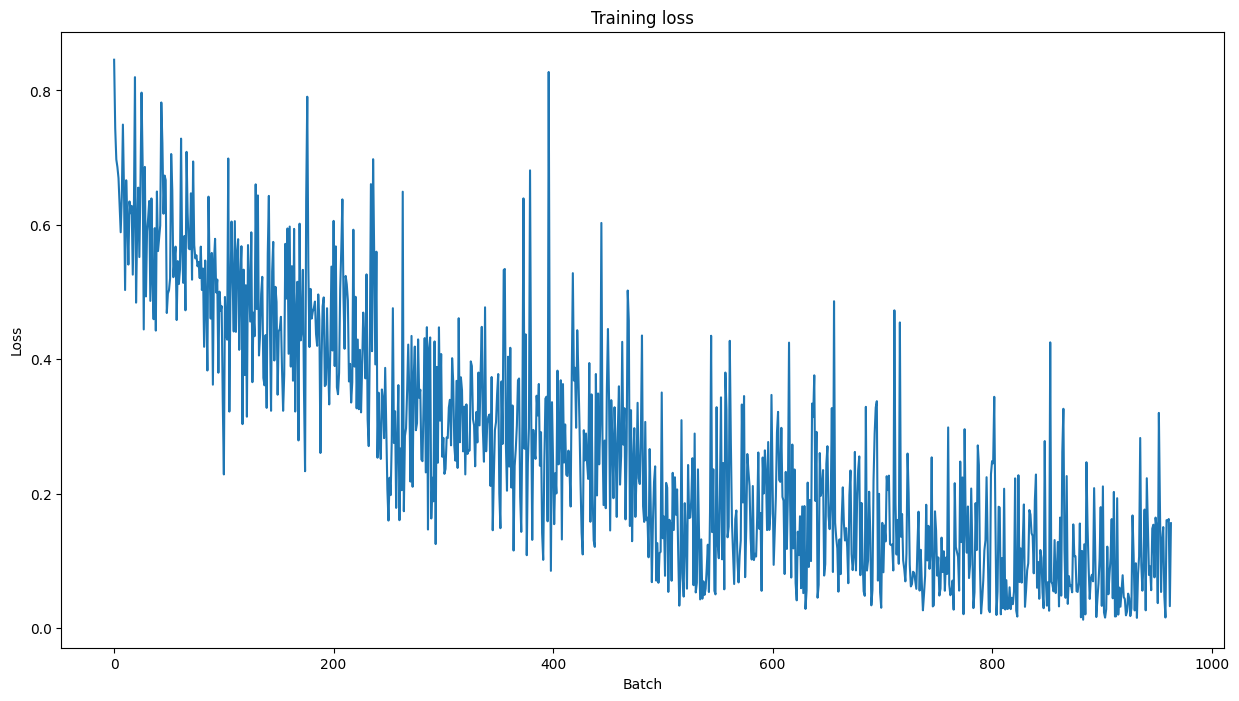

In [31]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [32]:
#@title Predicting and Evaluating Using the Holdout Dataset 【预测】
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [33]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
print(predictions)
print(true_labels)

#Evaluating using the Matthews Correlation Coefficient

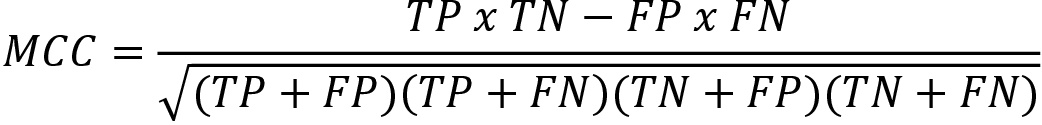

In [35]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/03/B17948_03_005.png', width=800) #This is used for rendering images in the notebook

In [36]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.
最终得分将基于整个测试集，但让我们看一下单个批次的得分，以了解不同批次之间的指标变化。

In [37]:
#@title Score of Individual Batches
matthews_set

[0.17054221752815663,
 -0.15114173098063566,
 0.4040950971038548,
 0.39405520311955033,
 0.32328707534629597,
 0.7410010097502685,
 0.4472135954999579,
 0.0,
 0.9165151389911681,
 0.8246211251235321,
 0.7679476477883045,
 0.8320502943378436,
 0.8150678894028793,
 0.7141684885491869,
 0.3268228676411533,
 0.5844155844155844,
 0.0]

In [38]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5451320542303817